In [52]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns
import random

<center>============== Data Preparation ==============</center>

== Data preprocessing == 
1. The modes is a binary feature (Major/Minor), So I replaced the text with Boolean Values (Major = 1, Minor = 0)
2. The key can be seen as a categorical feature, which can be encoded by integers (I kept the original key column for easier understanding e.g. C# = 4, F# = 9)
3. Same process for genre
4. Dropped time_signature, since I don't think it's relevant, or important, to ML. 

In [72]:
music_set = pd.read_csv('./SpotifyFeatures.csv')
music_set.dropna()
music_set.drop_duplicates('track_id', inplace=True)
data = music_set.copy()
# Convert mode to boolean values
data['mode'] = (data['mode'] == 'Major').astype(int)

# Convert 'key' to category data type
data['key'] = pd.Categorical(data['key'])

# Create a new column with integer encoding for 'key'
data['key_encoded'] = data['key'].cat.codes

# Drop the original 'key' column (optional)
#data = data.drop('key', axis=1)

# Convert 'genre' to category data type
data['genre'] = pd.Categorical(data['genre'])

# Create a new column with integer encoding for 'genre'
data['genre_encoded'] = data['genre'].cat.codes

# Drop the original 'genre' column (optional)
#data = data.drop('genre', axis=1)

# Drop 'time_signature' column
data = data.drop('time_signature', axis=1)

In [54]:
data.dtypes

genre               category
artist_name           object
track_name            object
track_id              object
popularity             int64
acousticness         float64
danceability         float64
duration_ms            int64
energy               float64
instrumentalness     float64
key                 category
liveness             float64
loudness             float64
mode                   int32
speechiness          float64
tempo                float64
valence              float64
key_encoded             int8
genre_encoded           int8
dtype: object

== Data Scaling ==
1. I've select all numerical feature for scaling. StandScaler does not consider the relationship between each features, this might need to be discussed in the meeting. However I do believe the "normal" scaling process is sufficient for our project

In [55]:
scaler = StandardScaler()
numerical_features = ['popularity','acousticness','danceability','duration_ms',
                          'energy','instrumentalness','liveness','loudness','speechiness',
                          'tempo','valence']

data[numerical_features] = scaler.fit_transform(data[numerical_features])

<center>============== Data Preparation END==============</center>

== Data Analysis ==

From below correlation matrix:
* Popularity correlated to Danceability, Energy, Loudness 
* Acousticness correlated to Instrumentalness 
* Danceability correlated to Energy, Loudness, Valence
* Duration: no affect
* Energy correlated to Loudness, Valence, Danceability, little bit of Popularity
* Liveness correlated to Speechiness
* Loudness is highly correlated with Energy, and relatively high correlated to Popularity, Danceability, Valence 
* Speechiness correlated to Liveness 
* Tempo correlated to loudness and Energy 
* Valence correlated to Danceability, Loudness, Energy 

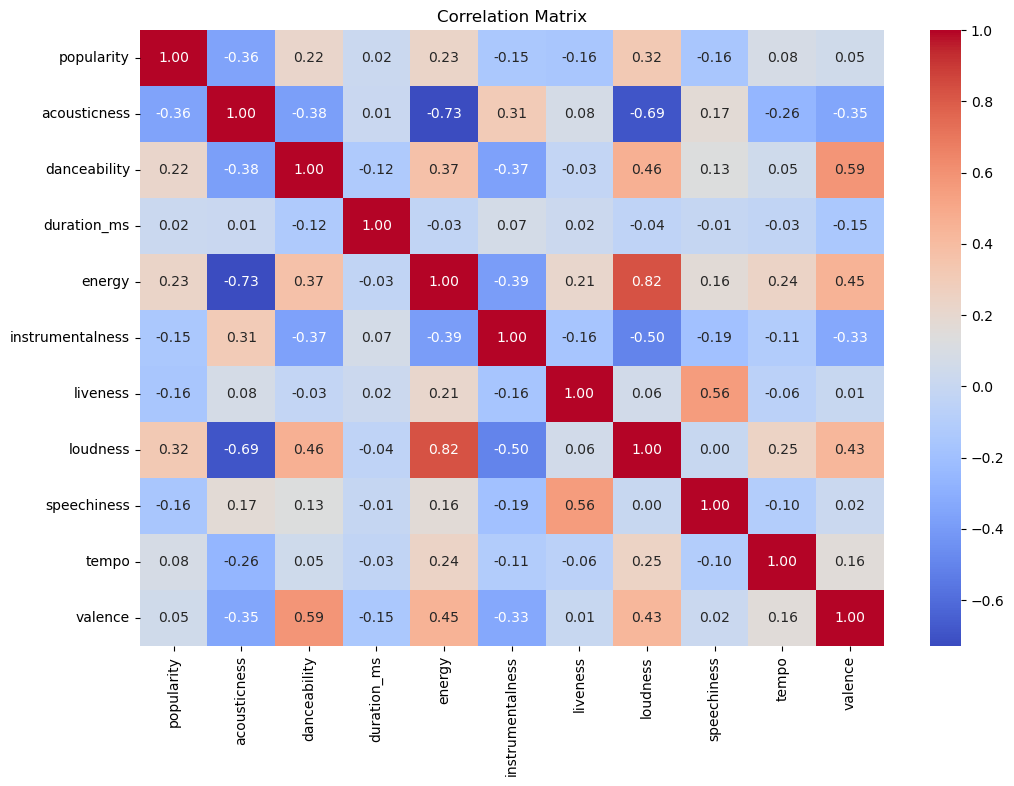

In [56]:

# Calculate correlation matrix
correlation_matrix = data[numerical_features].corr()

# Plot heatmap of the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()


<center>============== Training ==============</center>

In [83]:
selected_features = ['genre_encoded','popularity','acousticness',
                     'danceability','energy','instrumentalness','key_encoded',
                     'liveness','loudness','speechiness','tempo','valence']
X = data[selected_features].copy()
y = data['track_id'].copy()

X.values[10]

array([ 1.5000e+01,  0.0000e+00,  9.2100e-01,  1.9100e-01,  1.4500e-01,
        5.2900e-01,  7.0000e+00,  1.4100e-01, -1.7239e+01,  3.9300e-02,
        8.5225e+01,  8.4900e-02])

In [84]:
# Number of recommendations 
n = 10
knn_model = NearestNeighbors(n_neighbors=n, metric='euclidean',algorithm='auto')
knn_model.fit(X)


# Example query point (Replace with user input e.g. which song you like most?)
query_point = [[15, -2.085747, 0.564740,
                -0.798733, 1.279646, -0.532841,
                4, 0.575611, 1.299283,
                -0.366515, 1.588677, 1.353170]]

# Find k-nearest neighbors
distances, indices = knn_model.kneighbors(query_point)

# Reset index before retrieving recommended songs
recommended_songs = data.reset_index().loc[indices[0]]['track_id']

print("Recommended Songs:")
print(recommended_songs)


Recommended Songs:
52514     5CqNb44X1q3OEKCRgWhYdU
54        2BF5SlaZRL0sYUDBgwjmbo
132802    4oEihjaR6jlHxO0ipRGn2n
132154    6V67PVlhzbus3CDagsyT8d
164045    4zXCd6bBfkXhuzlIETTkNv
86924     2G8KmYY1MDR8P10cfJsdA8
129840    5UpFRm9dY85uhH5YQDZ1Df
68836     2GMNiQF0nZyxzWWPV5wAXX
66182     06W6KjnlxohJDxDFoXwfpY
130738    6POH9zavDGxaRIxaUZxAGY
Name: track_id, dtype: object


c:\Users\10186\.conda\envs\McMaster_Std_Env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


In [92]:
# Verify both ID and track_id is correct 
test = music_set.loc[music_set['track_id'] == '2BF5SlaZRL0sYUDBgwjmbo']
test


,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
54,Movie,Jean Piat,L'Âne chargé d'éponges et l'Âne chargé de sel,2BF5SlaZRL0sYUDBgwjmbo,0,0.924,0.683,101653,0.147,0.0,G#,0.606,-21.998,Major,0.822,32.244,4/4,0.595


In [94]:
music_set.values[10]

array(['Movie', 'Leopold Stokowski',
       'Symphony No.4 In E Minor Op.98 : IV. Allegro Energico E Passionato',
       '0XKgegoxLcIihK3Klpfo3N', 0, 0.921, 0.191, 566960, 0.145, 0.529,
       'E', 0.141, -17.239, 'Minor', 0.0393, 85.225, '4/4', 0.0849],
      dtype=object)

In [95]:
music_set.values[54]

array(['Movie', 'Jean Piat',
       "L'Âne chargé d'éponges et l'Âne chargé de sel",
       '2BF5SlaZRL0sYUDBgwjmbo', 0, 0.924, 0.683, 101653, 0.147, 0.0,
       'G#', 0.606, -21.998, 'Major', 0.822, 32.244, '4/4', 0.595],
      dtype=object)